# Analysis of Processed Slocum Glider-AD2CP Data: RU29 2020

In [1]:
# Imports
import scipy.interpolate as interp
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
import cmocean.cm as cmo
import sys

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'../src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data, dist_from_lat_lon

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Step 1: Load glider data

In [2]:
ds_id = 'ru29-20200908T1623-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
variables2 = ['depth', 'latitude', 'longitude', 'time', 'temperature', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf.columns = variables2


## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

## Format time
gdf.time = pd.to_datetime(gdf.time.values).tz_localize(None).values

gdf

# x=10
# plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])

,depth,latitude,longitude,time,temperature,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
0,0.00000,18.175290,-64.802942,2020-09-08 16:23:40.150,0.0000,0.00000,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,NaN
1,0.00000,18.175290,-64.802942,2020-09-08 16:23:47.430,0.0000,0.00000,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,NaN
2,NaN,18.175290,-64.802942,2020-09-08 16:23:47.560,NaN,NaN,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,1.80293
3,NaN,18.175290,-64.802942,2020-09-08 16:24:48.430,NaN,NaN,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,1.80293
4,NaN,18.176045,-64.804093,2020-09-08 16:25:14.450,NaN,NaN,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5087216,0.18886,18.139090,-64.784373,2020-11-12 07:31:32.760,27.6073,5.43973,ru29-2020-315-0-9-mbd(04470009),NaN,NaN,NaN
5087217,0.18886,18.139090,-64.784373,2020-11-12 07:31:34.770,27.6072,5.43980,ru29-2020-315-0-9-mbd(04470009),NaN,NaN,NaN
5087218,0.14910,18.139090,-64.784373,2020-11-12 07:31:36.790,27.6093,5.43990,ru29-2020-315-0-9-mbd(04470009),NaN,NaN,NaN
5087219,0.15904,18.139090,-64.784373,2020-11-12 07:31:38.800,27.6093,5.43993,ru29-2020-315-0-9-mbd(04470009),NaN,NaN,NaN


## Step 2: Load processed AD2CP data

In [3]:
#path = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Processed/"

dz=10
path = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Processed_{}_meter_vertical_resolution/".format(dz)
files = np.sort(glob.glob(path+'*.csv'))
df = pd.concat(map(pd.read_csv, files))

df

,Unnamed: 0,inversion_u,inversion_v,inversion_depth,start_lon,start_lat,end_lon,end_lat,start_tm,end_tm,obs_per_bin
0,0,-0.223677,0.145673,5.0,-64.814393,18.062857,-64.812228,18.085668,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z,614.0
1,1,-0.217124,0.148769,15.0,-64.814393,18.062857,-64.812228,18.085668,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z,6420.0
2,2,-0.218544,0.153487,25.0,-64.814393,18.062857,-64.812228,18.085668,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z,5644.0
3,3,-0.217001,0.121161,35.0,-64.814393,18.062857,-64.812228,18.085668,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z,3421.0
4,4,-0.225148,0.132483,45.0,-64.814393,18.062857,-64.812228,18.085668,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z,2393.0
...,...,...,...,...,...,...,...,...,...,...,...
93,93,-0.013606,0.018232,935.0,-64.800935,17.857937,-64.799647,17.827635,2020-10-08T08:07:10.76Z,2020-10-08T11:09:50.52Z,1704.0
94,94,-0.016435,0.014852,945.0,-64.800935,17.857937,-64.799647,17.827635,2020-10-08T08:07:10.76Z,2020-10-08T11:09:50.52Z,1612.0
95,95,-0.013385,0.018079,955.0,-64.800935,17.857937,-64.799647,17.827635,2020-10-08T08:07:10.76Z,2020-10-08T11:09:50.52Z,1532.0
96,96,-0.013489,0.019999,965.0,-64.800935,17.857937,-64.799647,17.827635,2020-10-08T08:07:10.76Z,2020-10-08T11:09:50.52Z,1666.0


In [4]:
inversion_dz = np.diff(df.inversion_depth)[0].astype(int)
inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+inversion_dz,inversion_dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU29 2020 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds = ds.sortby(ds.time)
ds

<xarray.Dataset>
Dimensions:     (depth: 98, time: 242)
Coordinates:
  * time        (time) datetime64[ns] 2020-10-02T04:20:23.550000 ... 2020-11-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
Data variables:
    u_grid      (depth, time) float64 -0.2862 -0.3009 -0.2237 ... -0.00483 nan
    v_grid      (depth, time) float64 0.01931 0.06462 0.1457 ... 0.005272 nan
    latitude    (time) float64 18.03 18.05 18.07 18.1 ... 18.04 18.01 17.98
    longitude   (time) float64 -64.81 -64.81 -64.81 ... -64.79 -64.79 -64.8
    start_lat   (time) float64 18.01 18.04 18.06 18.09 ... 18.06 18.03 18.0
    start_lon   (time) float64 -64.81 -64.81 -64.81 ... -64.79 -64.79 -64.79
    end_lat     (time) float64 18.04 18.06 18.09 18.11 ... 18.03 18.0 17.97
    end_lon     (time) float64 -64.81 -64.81 -64.81 ... -64.79 -64.79 -64.8
    start_time  (time) datetime64[ns] 2020-10-02T01:15:52.840000 ... 2020-11-...
    end_time    (time) datetime64[ns] 2020-10-02T04:20:23.550000 ... 2020-11-...
Attributes:
    description:  Master/combined RU29 2020 AD2CP least-squares inversion vel...

## Section Timing

In [5]:
sect_times1 = pd.read_csv('/home/jg1200/Data/GliderData/RU29/anagada_section_times.csv')
sect_times1.starttime = np.array(sect_times1.starttime,dtype=np.datetime64)
sect_times1.endtime = np.array(sect_times1.endtime,dtype=np.datetime64)
## This is the OG
sect_times = sect_times1.iloc[7:-1,:]
sect_times


,section_number,starttime,endtime
7,7,2020-10-15 09:07:30,2020-10-17 00:31:58
8,8,2020-10-17 00:31:58,2020-10-18 13:53:20
9,9,2020-10-18 13:53:20,2020-10-20 06:44:54
10,10,2020-10-20 06:44:54,2020-10-21 17:10:48
11,11,2020-10-21 17:10:48,2020-10-23 07:00:58
12,12,2020-10-23 07:00:58,2020-10-24 18:42:06
13,13,2020-10-24 18:42:06,2020-10-26 10:57:09
14,14,2020-10-26 10:57:09,2020-10-27 21:53:33
15,15,2020-10-27 21:53:33,2020-10-29 15:06:27
16,16,2020-10-29 15:06:27,2020-10-31 03:11:10


## Loop to pull out DACs and stick in a dataframe

In [6]:
vx = np.empty(len(start_times))
vx[:] = np.NaN
vy = np.empty(len(start_times))
vy[:] = np.NaN
vx_start_lon = np.empty(len(start_times))
vx_start_lon[:] = np.NaN
vx_start_lat = np.empty(len(start_times))
vx_start_lat[:] = np.NaN
vx_end_lon = np.empty(len(start_times))
vx_end_lon[:] = np.NaN
vx_end_lat = np.empty(len(start_times))
vx_end_lat[:] = np.NaN
vx_start_tm = np.empty(len(start_times),dtype=pd.Timestamp)
vx_end_tm = np.empty(len(start_times),dtype=pd.Timestamp)


for x in np.arange(0,len(start_times)):

    ## Subset glider df to one segment
    subsetgdf = gdf[(gdf.time >= start_times2[x]) & (gdf.time <= end_times2[x])]
    ## Pull out last non-NaN DAC
    ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()
    
    ## Check if there is a DAC, if not continue onto next segment.
    if len(ind) > 0:
        vx[x]          = subsetgdf.m_water_vx.iloc[ind[-1]]
        vy[x]         = subsetgdf.m_water_vy.iloc[ind[-1]]
        
        ## Pull out last non-NaN lat/lon
        ind1         = np.argwhere(np.isnan(subsetgdf.longitude).ravel()==False).flatten()   
        vx_start_lon[x] = subsetgdf.longitude.iloc[ind1[0]]
        vx_start_lat[x] = subsetgdf.latitude.iloc[ind1[0]]
        vx_end_lon[x]   = subsetgdf.longitude.iloc[ind1[-1]]
        vx_end_lat[x]   = subsetgdf.latitude.iloc[ind1[-1]]
        ## Not using the index here because I want the segment start and end times
        vx_start_tm[x]  = subsetgdf.time.iloc[0]
        vx_end_tm[x]    = subsetgdf.time.iloc[-1]


In [7]:
data = {'vx': vx, 'vy': vy, 'start_lon': vx_start_lon, 'start_lat': vx_start_lat, 'end_lon': vx_end_lon,
       'end_lat': vx_end_lat, 'start_time': vx_start_tm, 'end_time': vx_end_tm}

DACdf = pd.DataFrame(data)
DACdf


,vx,vy,start_lon,start_lat,end_lon,end_lat,start_time,end_time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
2,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...
1076,-0.039627,0.010190,-64.786398,18.168172,-64.788425,18.163332,2020-11-16 11:05:42.450,2020-11-16 12:25:10.040
1077,-0.039627,0.010190,-64.788425,18.163332,-64.788425,18.163332,2020-11-16 12:30:35.990,2020-11-16 12:32:36.860
1078,-0.122072,0.085841,-64.788425,18.163332,-64.789908,18.163992,2020-11-16 12:32:47.510,2020-11-16 13:00:22.810
1079,-0.025824,0.027190,-64.784288,18.139775,-64.784373,18.139090,2020-11-12 04:10:58.940,2020-11-12 07:20:50.870


## Load just science data now

In [36]:
ds_id = 'ru29-20200908T1623-profile-sci-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'salinity', 'temperature','density','source_file', 'profile_id','m_pitch']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables


## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

## Format time
gdf.time = pd.to_datetime(gdf.time.values).tz_localize(None).values

#gdf.density = gdf.density+1000

gdf


,depth,latitude,longitude,time,salinity,temperature,density,source_file,profile_id,m_pitch
0,0.139160,18.176980,-64.805536,2020-09-08 16:26:37,34.925755,29.7325,1021.76230,ru29-2020-251-4-0-mbd(04270000),1599582780,NaN
1,NaN,18.176990,-64.805546,2020-09-08 16:26:38,NaN,NaN,NaN,ru29-2020-251-4-0-mbd(04270000),1599582780,NaN
2,0.159039,18.177001,-64.805555,2020-09-08 16:26:39,34.923603,29.7288,1021.76210,ru29-2020-251-4-0-mbd(04270000),1599582780,NaN
3,NaN,18.177012,-64.805565,2020-09-08 16:26:40,NaN,NaN,NaN,ru29-2020-251-4-0-mbd(04270000),1599582780,NaN
4,0.159039,18.177022,-64.805575,2020-09-08 16:26:41,34.925000,29.7280,1021.76337,ru29-2020-251-4-0-mbd(04270000),1599582780,NaN
...,...,...,...,...,...,...,...,...,...,...
4951791,0.188860,18.163975,-64.789906,2020-11-16 12:58:58,34.743874,28.0090,1022.20080,ru29-2020-315-0-76-mbd(04470076),1599583881,NaN
4951792,0.238559,18.163982,-64.789903,2020-11-16 12:59:00,34.743202,28.0097,1022.20026,ru29-2020-315-0-76-mbd(04470076),1599583881,NaN
4951793,0.159040,18.163988,-64.789900,2020-11-16 12:59:02,34.744360,28.0074,1022.20154,ru29-2020-315-0-76-mbd(04470076),1599583881,NaN
4951794,NaN,18.163988,-64.789900,2020-11-16 12:59:02,NaN,NaN,NaN,ru29-2020-315-0-76-mbd(04470076),1599583881,NaN


## Test subset

In [37]:
y=1
subset_ds_sect = ds.sel(time=slice(sect_times.starttime.values[y], sect_times.endtime.values[y]))
gdf2 = gdf.loc[(gdf.time >= subset_ds_sect.start_time.values[0]) & (gdf.time <= subset_ds_sect.end_time.values[-1])]

subset_ds_sect
    

<xarray.Dataset>
Dimensions:     (depth: 98, time: 12)
Coordinates:
  * time        (time) datetime64[ns] 2020-10-17T01:13:26.030000 ... 2020-10-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
Data variables:
    u_grid      (depth, time) float64 -0.04086 0.04973 ... 0.00296 -0.01111
    v_grid      (depth, time) float64 0.0432 -0.004467 ... 0.008757 0.01336
    latitude    (time) float64 18.14 18.14 18.11 18.08 ... 17.89 17.86 17.84
    longitude   (time) float64 -64.79 -64.79 -64.79 -64.79 ... -64.8 -64.8 -64.8
    start_lat   (time) float64 18.12 18.16 18.13 18.1 ... 17.91 17.88 17.85
    start_lon   (time) float64 -64.79 -64.78 -64.79 -64.79 ... -64.8 -64.8 -64.8
    end_lat     (time) float64 18.16 18.13 18.1 18.06 ... 17.88 17.85 17.82
    end_lon     (time) float64 -64.78 -64.79 -64.79 -64.79 ... -64.8 -64.8 -64.8
    start_time  (time) datetime64[ns] 2020-10-16T22:04:23.630000 ... 2020-10-...
    end_time    (time) datetime64[ns] 2020-10-17T01:13:26.030000 ... 2020-10-...
Attributes:
    description:  Master/combined RU29 2020 AD2CP least-squares inversion vel...

Text(0.5, 1.0, 'RU29 October 2020')

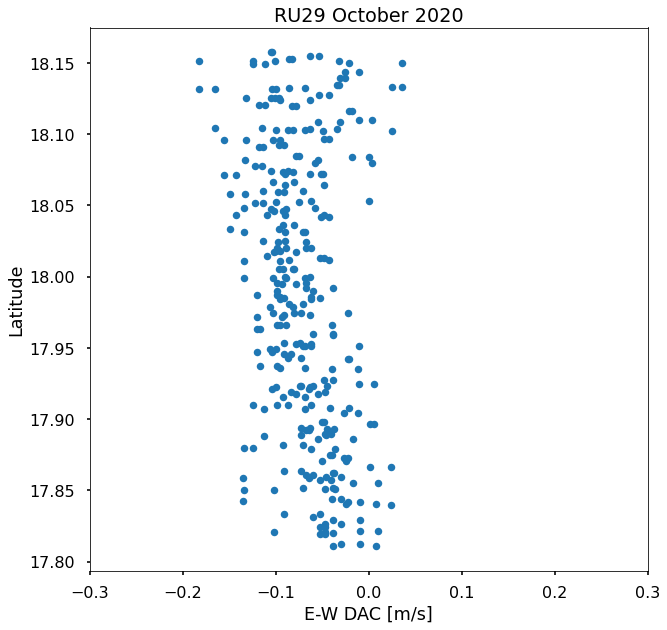

In [654]:
DACdf2 = DACdf.loc[(DACdf.start_time >= sect_times.starttime.values[0]) & (DACdf.end_time <= sect_times.starttime.values[-1])]

plt.figure(figsize=(10,10))
plt.plot(DACdf2.vx,DACdf2.start_lat,'.',markersize=15)
plt.xlim(-0.3,0.3)
plt.xlabel('E-W DAC [m/s]')
plt.ylabel('Latitude')
plt.title('RU29 October 2020')

In [652]:
DACdf2

,vx,vy,start_lon,start_lat,end_lon,end_lat,start_time,end_time
877,0.036668,0.024264,-64.796557,17.839980,-64.798373,17.811477,2020-11-06 11:17:11.970,2020-11-06 14:22:25.340
878,0.036668,0.024264,-64.798373,17.811477,-64.798373,17.811477,2020-11-06 14:31:58.350,2020-11-06 14:33:55.060
879,0.023303,-0.010336,-64.798373,17.811477,-64.799195,17.840528,2020-11-06 14:34:06.650,2020-11-06 17:44:44.820
880,0.023303,-0.010336,-64.799195,17.840528,-64.799195,17.840528,2020-11-06 17:55:09.540,2020-11-06 17:57:05.850
881,0.004109,0.010105,-64.799195,17.840528,-64.800442,17.875165,2020-11-06 17:57:17.850,2020-11-06 21:05:54.190
882,0.004109,0.010105,-64.800442,17.875165,-64.800442,17.875165,2020-11-06 21:14:44.450,2020-11-06 21:16:40.700
883,-0.010536,0.033138,-64.800442,17.875165,-64.800117,17.912197,2020-11-06 21:16:50.100,2020-11-07 00:26:31.970
884,-0.010536,0.033138,-64.800117,17.912197,-64.800117,17.912197,2020-11-07 00:36:54.310,2020-11-07 00:38:52.760
886,-0.028432,0.035032,-64.800117,17.912197,-64.798370,17.947645,2020-11-07 00:39:01.590,2020-11-07 03:43:40.750
887,-0.028432,0.035032,-64.798370,17.947645,-64.798370,17.947645,2020-11-07 03:52:08.910,2020-11-07 03:54:10.690


# Grid Interpolation

Doing it on a finer grid (both latitudinally and depth wise) may lead to a better thermal wind estimate

In [569]:
# What do we want dz here to be

geo_dz = 2

griddepth = np.arange(0,1001,geo_dz)

## I think this works well
lat_grid = np.arange(17.85,18.11,0.05) ## fine grid (18.11 so that 0.5 spacing includes 18.1)
## Not bad
#lat_grid = np.arange(17.86,18.13,0.03) ## fine grid (18.11 so that 0.5 spacing includes 18.1)

#lat_grid = np.arange(17.9,18.11,0.05) ## fine grid (18.11 so that 0.5 spacing includes 18.1)
#lat_grid = np.arange(17.8,18.16,0.1) ## coarse grid


lon_grid = np.repeat(-64.80,8) # Just make it -64.80

X, Y, Z = np.meshgrid(lon_grid, lat_grid, griddepth)


gridtemp = np.empty((len(griddepth),len(lat_grid),15))
gridtemp[:] = np.NaN
gridsalinity = np.empty((len(griddepth),len(lat_grid),15))
gridsalinity[:] = np.NaN
griddensity = np.empty((len(griddepth),len(lat_grid),15))
griddensity[:] = np.NaN
gridvx = np.empty((len(lat_grid),15))
gridvx[:] = np.NaN


for y in np.arange(0,15):

    ## ADCP
    subset_ds_sect = ds.sel(time=slice(sect_times.starttime.values[y], sect_times.endtime.values[y]))
    gdf2 = gdf.loc[(gdf.time >= subset_ds_sect.start_time.values[0]) & (gdf.time <= subset_ds_sect.end_time.values[-1])]    
    DACdf2 = DACdf.loc[(DACdf.start_time >= subset_ds_sect.start_time.values[0]) & (DACdf.end_time <= subset_ds_sect.end_time.values[-1])]

    profile_IDs = np.unique(gdf2.profile_id)
    profileid_start_index = np.empty(len(profile_IDs),dtype='int')
    profileid_end_index = np.empty(len(profile_IDs),dtype='int')
    
    for x in np.arange(0,len(profile_IDs)):
        profileid_start_index[x] = np.where(gdf2.profile_id == profile_IDs[x])[0][0]
        profileid_end_index[x] = np.where(gdf2.profile_id == profile_IDs[x])[0][-1]
    
    tgriddensity = np.empty((len(griddepth),len(profile_IDs)))
    tgriddensity[:] = np.NaN
    tgridtemp = np.empty((len(griddepth),len(profile_IDs)))
    tgridtemp[:] = np.NaN
    tgridsalinity = np.empty((len(griddepth),len(profile_IDs)))
    tgridsalinity[:] = np.NaN
    profile_lats = np.empty((len(profile_IDs)))
    profile_lats[:] = np.NaN
    profile_lons = np.empty((len(profile_IDs)))
    profile_lons[:] = np.NaN
    
    
    ## Interpolate depth
    for x in np.arange(0,len(profile_IDs)):
        tgriddensity[:,x] = interp.griddata(gdf2.depth.values[profileid_start_index[x]:profileid_end_index[x]],gdf2.density.values[profileid_start_index[x]:profileid_end_index[x]],griddepth)
        tgridtemp[:,x] = interp.griddata(gdf2.depth.values[profileid_start_index[x]:profileid_end_index[x]],gdf2.temperature.values[profileid_start_index[x]:profileid_end_index[x]],griddepth)
        tgridsalinity[:,x] = interp.griddata(gdf2.depth.values[profileid_start_index[x]:profileid_end_index[x]],gdf2.salinity.values[profileid_start_index[x]:profileid_end_index[x]],griddepth)
        profile_lats[x] = gdf2.latitude.values[profileid_start_index[x]]
        profile_lons[x] = gdf2.longitude.values[profileid_start_index[x]]

    ## Drop columns of all nan
    tgridtemp = tgridtemp[:,~np.isnan(tgridtemp).all(axis=0)]
    tgridsalinity = tgridsalinity[:,~np.isnan(tgridsalinity).all(axis=0)]
    tgriddensity = tgriddensity[:,~np.isnan(tgriddensity).all(axis=0)]
    
    gridvx[:,y] = interp.griddata(DACdf2.start_lat.values, DACdf2.vx.values, lat_grid, method='nearest')
    
    ## Interpolate latitude
    for x in np.arange(0,len(griddepth)):
        gridtemp[x,:,y] = interp.griddata(profile_lats, tgridtemp[x,:], lat_grid, method='nearest')
        gridsalinity[x,:,y] = interp.griddata(profile_lats, tgridsalinity[x,:], lat_grid, method='nearest')
        griddensity[x,:,y] = interp.griddata(profile_lats, tgriddensity[x,:], lat_grid, method='nearest')

totgriddensity = np.nanmean(griddensity,axis=2)




/tmp/ipykernel_99449/3441019895.py:79: RuntimeWarning: Mean of empty slice
  totgriddensity = np.nanmean(griddensity,axis=2)


/tmp/ipykernel_99449/3371976348.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,totgriddensity,cmap=cmo.dense)


Text(0.5, 1.0, 'Deployment Mean Density')

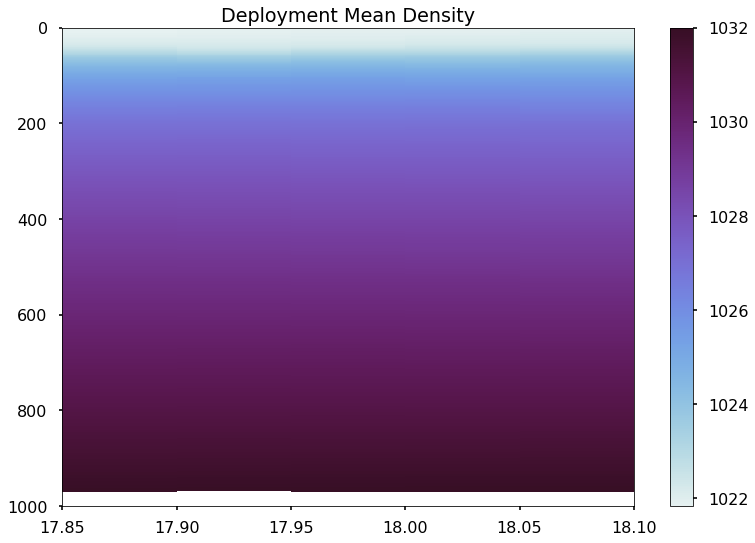

In [570]:
plt.pcolormesh(lat_grid,griddepth,totgriddensity,cmap=cmo.dense)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Deployment Mean Density')

/tmp/ipykernel_99449/3294384636.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,griddensity[:,:,1],cmap=cmo.dense)


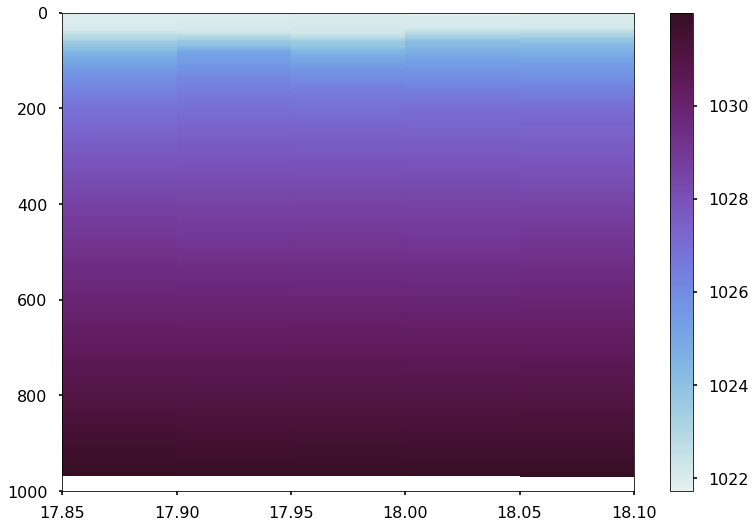

In [575]:
plt.pcolormesh(lat_grid,griddepth,griddensity[:,:,1],cmap=cmo.dense)
plt.gca().invert_yaxis()
plt.colorbar()

## Calculate $\frac{\partial \rho}{\partial y}$

In [576]:
distance = dist_from_lat_lon(lat_grid[0], lon_grid[0], lat_grid[1], lon_grid[0])
distance

5561.491661479939

In [578]:
#d_rho_dy = np.diff(griddensity,axis=1)/distance
d_rho_dy = np.gradient(griddensity,distance,axis=1)

tot_d_rho_dy = np.gradient(totgriddensity,distance,axis=1)

/tmp/ipykernel_99449/1447371370.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,tot_d_rho_dy)


Text(0.5, 1.0, 'Deployment Averaged')

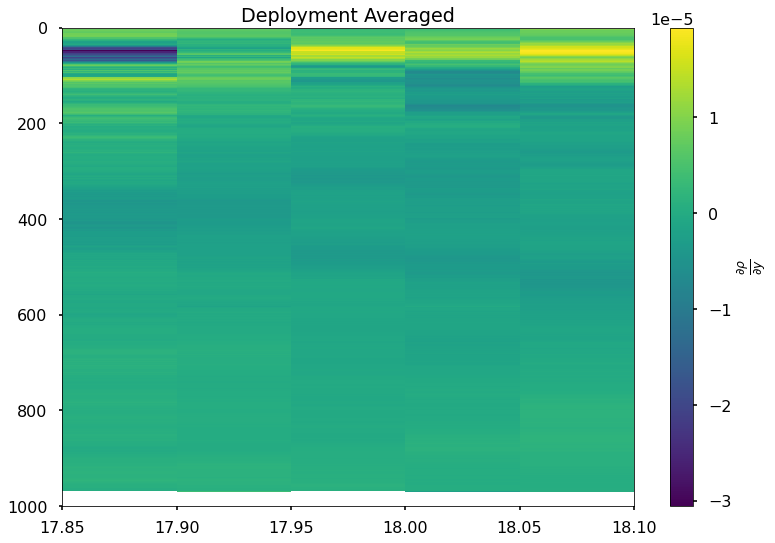

In [579]:
plt.pcolormesh(lat_grid,griddepth,tot_d_rho_dy)
plt.colorbar(label = r'$\frac{\partial \rho}{\partial y}$')
plt.gca().invert_yaxis()
plt.title('Deployment Averaged')


/tmp/ipykernel_99449/596945473.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,d_rho_dy[:,:,3])


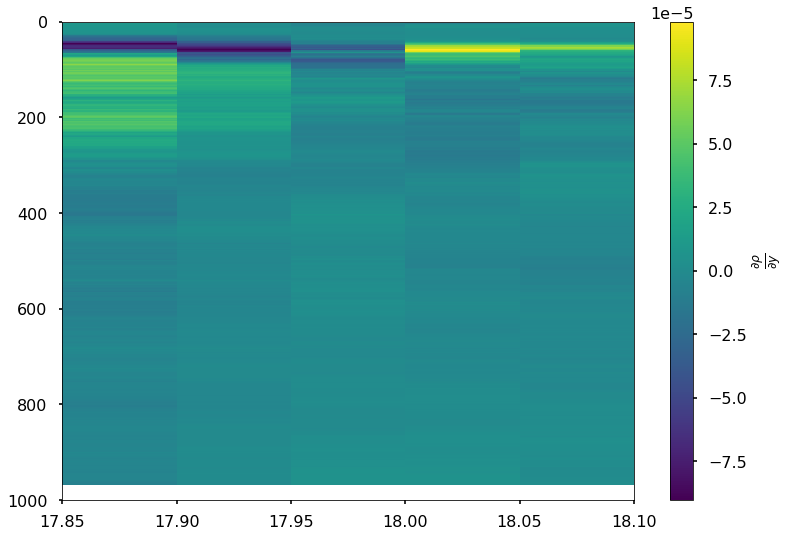

In [580]:
plt.pcolormesh(lat_grid,griddepth,d_rho_dy[:,:,3])
plt.colorbar(label = r'$\frac{\partial \rho}{\partial y}$')
plt.gca().invert_yaxis()

# get $\frac{\partial u}{\partial z}$

ok, now we have all the components of the right hand side to give us how the velocity changes with depth :

$$
\frac{g}{\rho f}\frac{\partial \rho}{\partial y}
$$

In [581]:
import seawater as sw

CF = sw.extras.f(ds.start_lat.mean())

g = sw.eos80.g(ds.start_lat.mean(), 0)

therm_wind = (1/CF)*(g/1027)*d_rho_dy
tot_therm_wind = (1/CF)*(g/1027)*tot_d_rho_dy

/tmp/ipykernel_99449/2750907907.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,tot_therm_wind,cmap='RdBu')


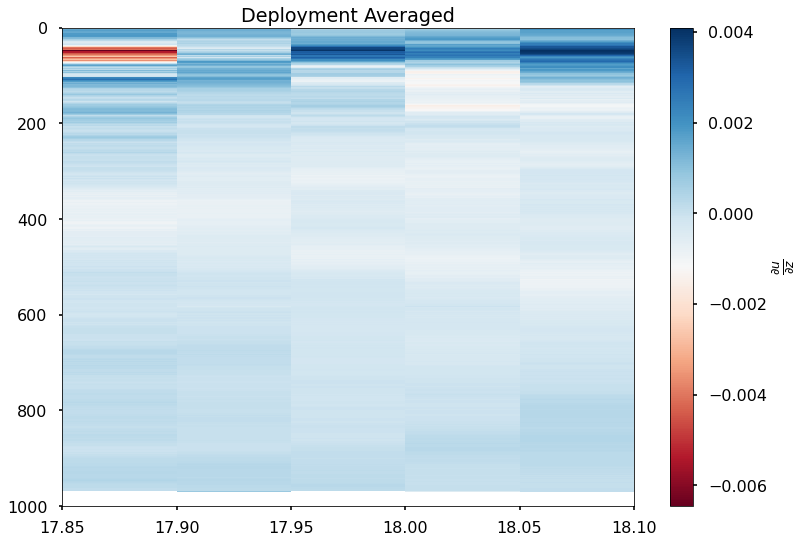

In [582]:
plt.pcolormesh(lat_grid,griddepth,tot_therm_wind,cmap='RdBu')
plt.title('Deployment Averaged')
plt.gca().invert_yaxis()
plt.colorbar(label = r'$\frac{\partial u}{\partial z}$')

/tmp/ipykernel_99449/4279662054.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,therm_wind[:,:,2],cmap='RdBu')


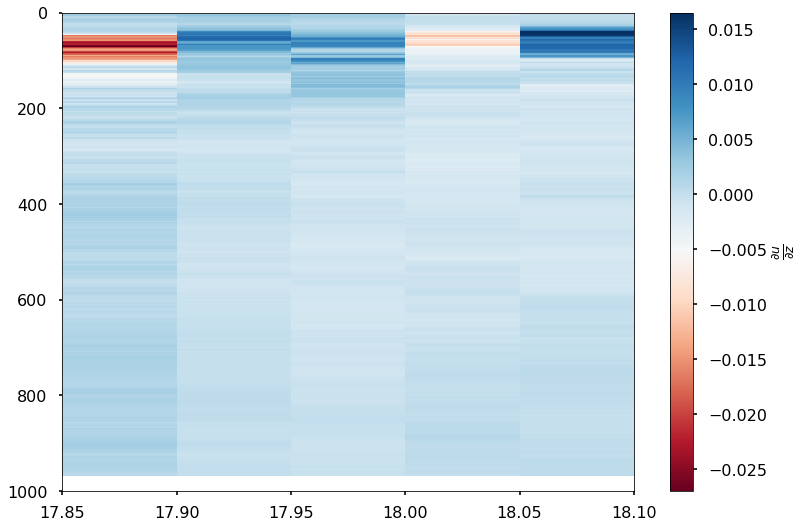

In [583]:
plt.pcolormesh(lat_grid,griddepth,therm_wind[:,:,2],cmap='RdBu')
plt.gca().invert_yaxis()
plt.colorbar(label = r'$\frac{\partial u}{\partial z}$')

/tmp/ipykernel_99449/4117987637.py:1: RuntimeWarning: Mean of empty slice
  plt.pcolormesh(lat_grid,griddepth,np.nanmean(therm_wind,axis=2),cmap='RdBu',vmin=-0.01,vmax=0.01)
/tmp/ipykernel_99449/4117987637.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,griddepth,np.nanmean(therm_wind,axis=2),cmap='RdBu',vmin=-0.01,vmax=0.01)


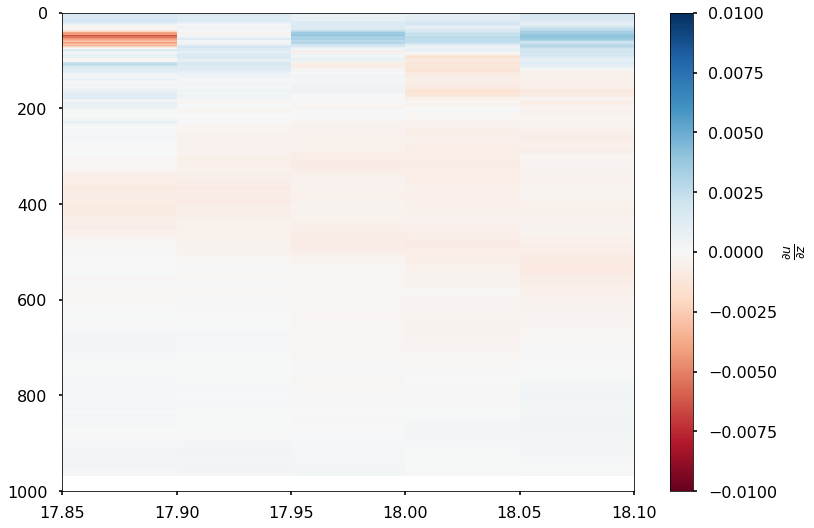

In [584]:
plt.pcolormesh(lat_grid,griddepth,np.nanmean(therm_wind,axis=2),cmap='RdBu',vmin=-0.01,vmax=0.01)
plt.gca().invert_yaxis()
plt.colorbar(label = r'$\frac{\partial u}{\partial z}$')

# Integrate vertically to get $u$

So far we have $\frac{\partial u}{\partial z}$, or how velocity changes with depth. But what  we would really like to know is the total velocity $u$. 

We can integrate the shear to get this!

$$
u = \int \frac{du}{dz}dz
$$


or actually each little step in $v$ looks like this (just re arrainging the equation):

$$
\Delta u = \frac{\Delta u}{\Delta z} * \Delta z
$$

if you sub in the thermal wind equation it looks like this:

$$
\Delta u = \frac{-g}{\rho f}\frac{\Delta \rho}{\Delta y} * \Delta z
$$

and if we want the total $u$ we can sum up all the little $\Delta u$'s from the water column to get a profile of $u$

This actually just gives us a `relative geostrophic velocity` something we will have to reference to get the absolute velocity

In [585]:
from scipy import integrate


# replace nan with zeros for integration
therm_wind[np.where(np.isnan(therm_wind) ==True)] = 0
tot_therm_wind[np.where(np.isnan(tot_therm_wind) ==True)] = 0

# flip to integrate from bottom, then flip back

rel_Vg = integrate.cumtrapz(therm_wind[::-1,:,:], dx=geo_dz, initial=0, axis=0)[::-1,:,:]
tot_rel_Vg = integrate.cumtrapz(tot_therm_wind[::-1,:], dx=geo_dz, initial=0, axis=0)[::-1,:]


Text(0.5, 1.0, 'Deployment Averaged Relative Geostrophic Velocity')

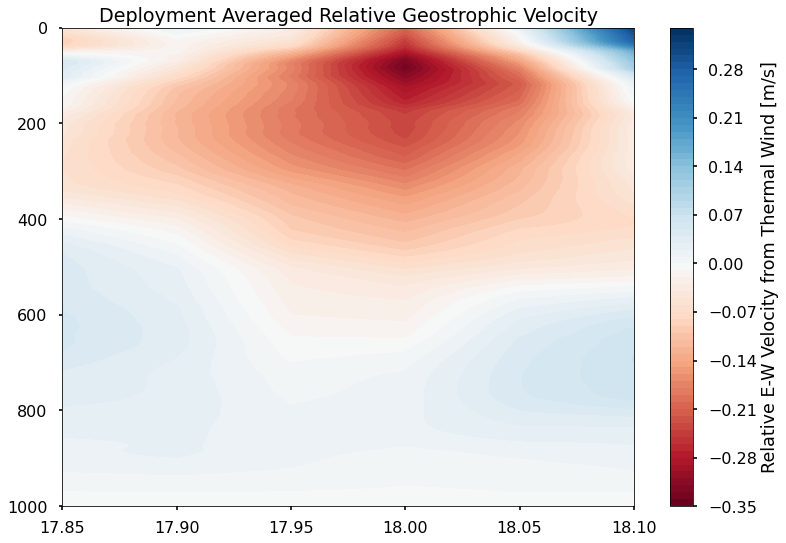

In [586]:
#plt.pcolormesh(lat_grid,griddepth,tot_rel_Vg,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.contourf(lat_grid,griddepth,tot_rel_Vg,cmap='RdBu',levels=np.arange(-0.35,0.35,0.01))
plt.colorbar(label='Relative E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()
plt.title('Deployment Averaged Relative Geostrophic Velocity')

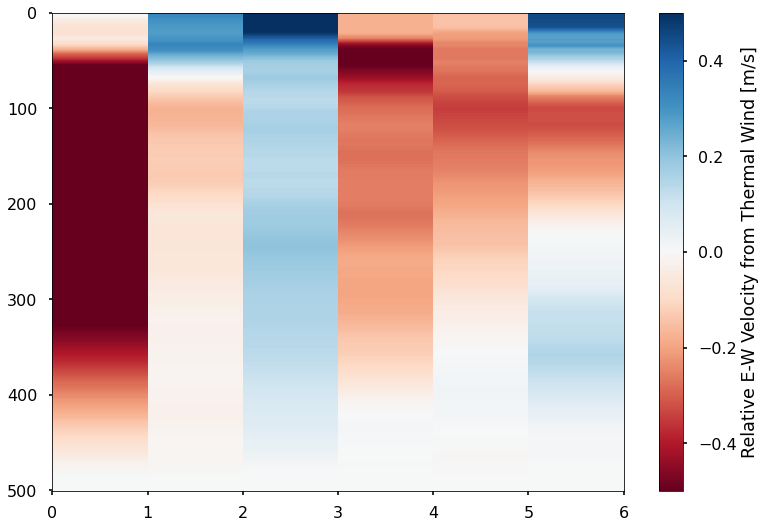

In [587]:
#plt.contourf(rel_Vg[:,:,7],cmap='RdBu',levels=np.arange(-0.5,0.5,0.025))
plt.pcolormesh(rel_Vg[:,:,7],cmap='RdBu',vmin=-0.5,vmax=0.5)
plt.colorbar(label='Relative E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

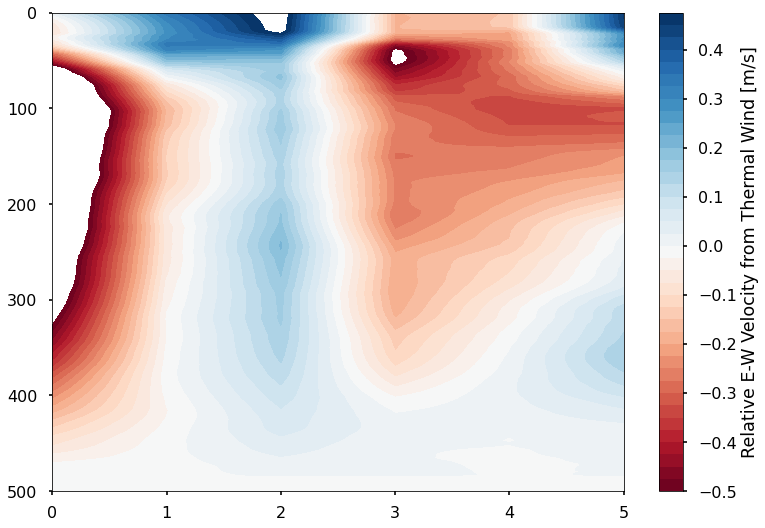

In [588]:
plt.contourf(rel_Vg[:,:,7],cmap='RdBu',levels=np.arange(-0.5,0.5,0.025))
plt.colorbar(label='Relative E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

In [589]:
mean_rel_Vg = np.nanmean(rel_Vg,axis=2)

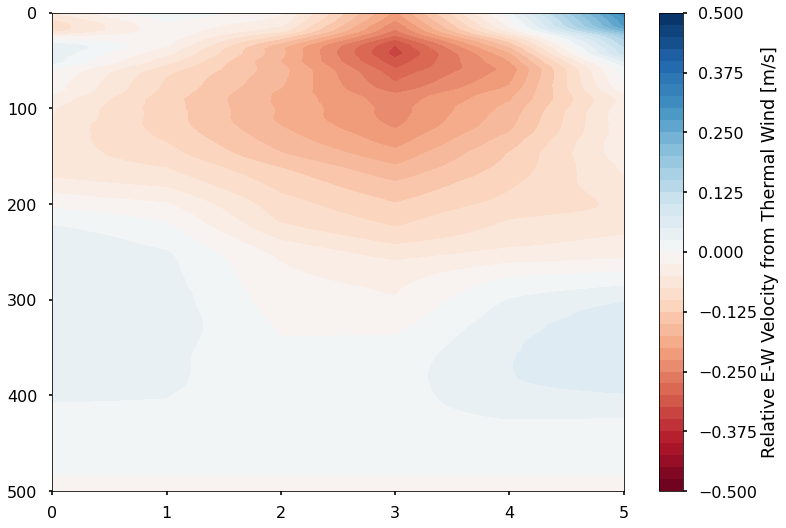

In [590]:
plt.contourf(mean_rel_Vg,cmap='RdBu',levels=np.arange(-0.5,0.51,0.025))
plt.colorbar(label='Relative E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

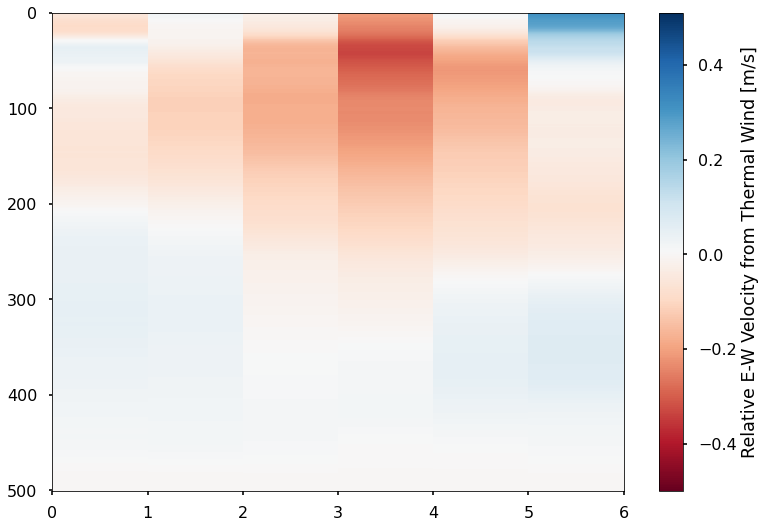

In [591]:
plt.pcolormesh(mean_rel_Vg,cmap='RdBu',vmin=-0.5,vmax=0.51)
plt.colorbar(label='Relative E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

# add the reference velocity

$$
V_{abs}(x,z) = V_{rel}(x,z) + V_{ref}(x)
$$

The reference, $V_{ref}$, is calculated from the DAC ($V_{dac}$) such that:

$$
V_{ref}(x) = V_{dac} - \frac{1}{h}\int_h V_{g}(x,z)dz
$$

In [592]:
vref = gridvx - np.nanmean(rel_Vg,axis=0)

Vgeo = rel_Vg + vref

mean_Vgeo = np.nanmean(Vgeo,axis=2)


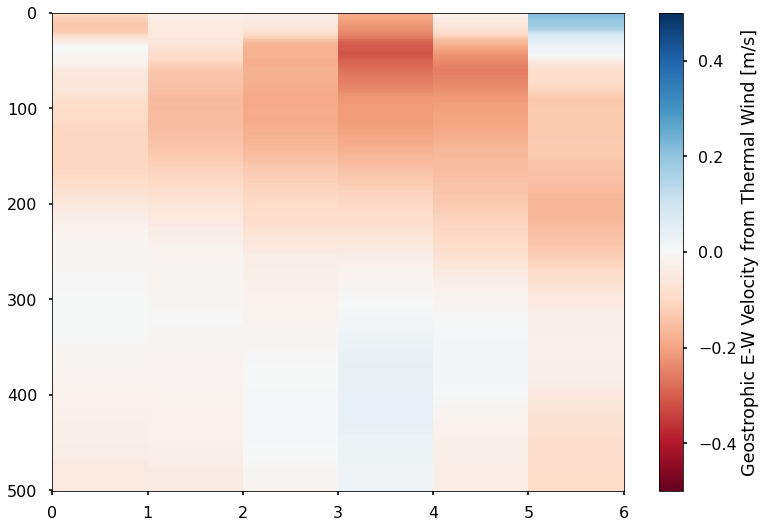

In [593]:
#plt.contourf(mean_Vgeo,cmap='RdBu',levels=np.arange(-0.5,0.51,0.025))
plt.pcolormesh(mean_Vgeo,cmap='RdBu',vmin=-0.5,vmax=0.5)
plt.colorbar(label='Geostrophic E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

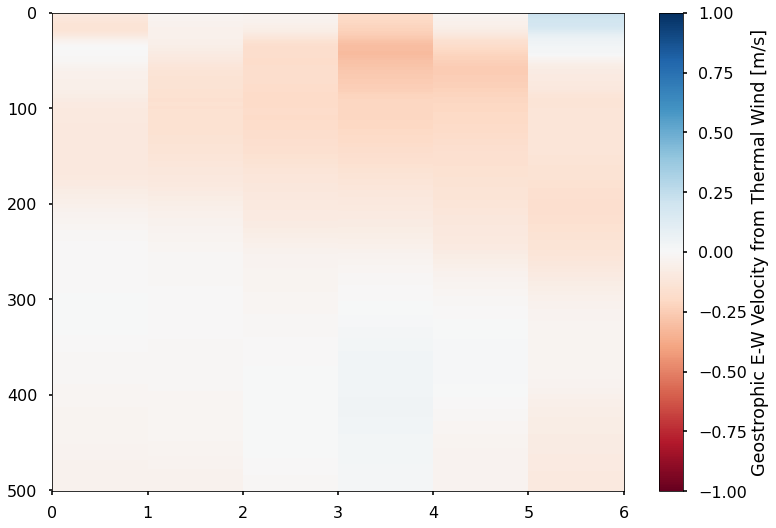

In [594]:
plt.pcolormesh(np.nanmean(Vgeo,axis=2),cmap='RdBu',vmin=-1,vmax=1)
plt.colorbar(label='Geostrophic E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

## Calculate Transport based off geostrophic velocity

In [595]:
distance = dist_from_lat_lon(lat_grid[0], lon_grid[0], lat_grid[1], lon_grid[0])
distance

5561.491661479939

## Put density on a finer grid than the ADCP data at first so now interpolate geostrophic velocity onto ADCP grid

In [596]:
Vgeo_interp = interp.griddata(griddepth,Vgeo,inversion_depth, method='linear')
Vgeo_interp.shape

(98, 6, 15)

In [597]:
geo_transport_gridu = np.empty(Vgeo_interp.shape[2])
geo_transport_gridu[:] = np.NaN
geo_transect_transport_profiles_u = np.empty((Vgeo_interp.shape[0],Vgeo_interp.shape[2]))
geo_transect_transport_profiles_u[:] = np.NaN
geo_transport_profiles_u = np.empty((Vgeo_interp.shape[0],Vgeo_interp.shape[1],Vgeo_interp.shape[2]))
geo_transport_profiles_u[:] = np.NaN

for x in np.arange(0,Vgeo_interp.shape[2]):
    geo_transport_gridu[x] = (np.nansum(Vgeo_interp[:,:,x]*inversion_dz*distance))/(10**6)
    geo_transect_transport_profiles_u[:,x] = np.nanmean((Vgeo_interp[:,:,x]*inversion_dz*distance)/(10**6),axis=1)
    for y in np.arange(0,Vgeo_interp.shape[1]):
        geo_transport_profiles_u[:,y,x] = (Vgeo_interp[:,y,x]*inversion_dz*distance)/(10**6)
    
## No loop needed for the deployment averaged transport
tot_geo_transport_gridu = (np.nansum(tot_rel_Vg[:,:]*geo_dz*distance))/(10**6)
tot_geo_transport_gridu


-1.1958796489048078

Text(0.5, 1.0, 'E-W Transport from Geostrophic Velocity\nRU29 October 2020')

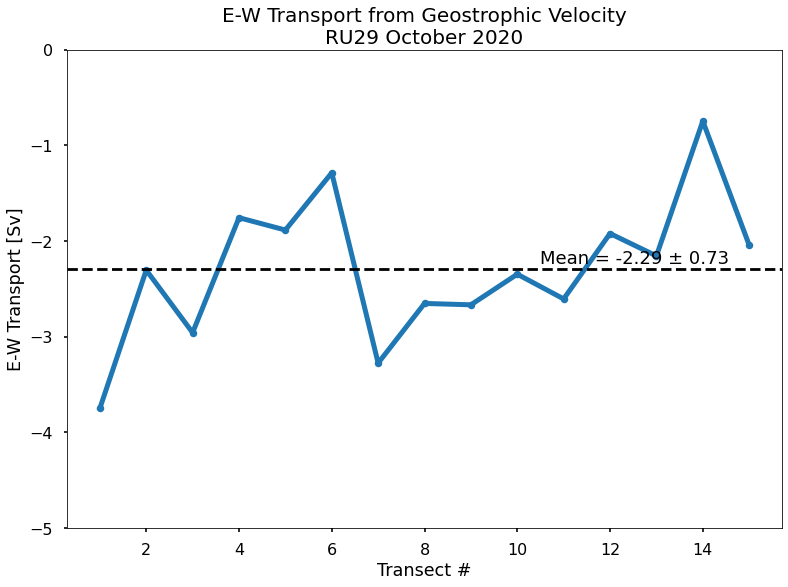

In [598]:
plt.plot(np.arange(1,16),geo_transport_gridu, linewidth=5,color='tab:blue')
plt.plot(np.arange(1,16),geo_transport_gridu, '.',color='tab:blue',markersize=15)
plt.ylabel('E-W Transport [Sv]')
plt.xlabel('Transect #')
plt.ylim(-5,0)
plt.axhline(y=np.nanmean(geo_transport_gridu), color='k', linestyle='--')
plt.text(10.5, np.nanmean(geo_transport_gridu)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(geo_transport_gridu),2),np.round(np.nanstd(geo_transport_gridu),2)),fontsize=18);
plt.title('E-W Transport from Geostrophic Velocity\nRU29 October 2020',fontsize=20)


Text(0.5, 1.0, 'RU29 2020 Anegada Passage')

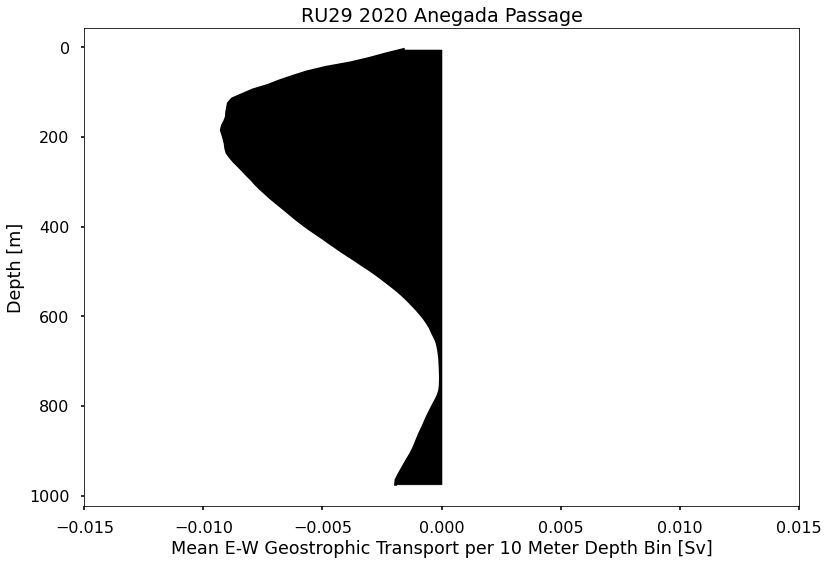

In [599]:
plt.plot(np.nanmean(geo_transect_transport_profiles_u,axis=1),inversion_depth,color='black')
plt.fill_betweenx(inversion_depth, 0,np.nanmean(geo_transect_transport_profiles_u,axis=1),color='black')
plt.xlim(-0.015,0.015)
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('Mean E-W Geostrophic Transport per 10 Meter Depth Bin [Sv]')
plt.title('RU29 2020 Anegada Passage')

## Interpolation Grid for Absolute Velocity Now

In [600]:
## Coarser lat grid 
#lat_grid = np.arange(17.85,18.11,0.05) ## fine grid (18.11 so that 0.5 spacing includes 18.1)
#lat_grid = np.arange(17.86,18.13,0.03) ## fine grid (18.11 so that 0.5 spacing includes 18.1)
#lat_grid = np.arange(17.9,18.11,0.05) ## fine grid 

## USE the grid from the geostrophy calculation


lon_grid = np.repeat(-64.80,len(lat_grid)) # Just make it -64.80
## Make grid
X, Y, Z = np.meshgrid(lon_grid, lat_grid, inversion_depth)

## This works for one transect
gridvelu = np.empty((len(inversion_depth),len(lat_grid),15))
gridvelu[:] = np.NaN
gridvelv = np.empty((len(inversion_depth),len(lat_grid),15))
gridvelv[:] = np.NaN
gridtemp = np.empty((len(inversion_depth),len(lat_grid),15))
gridtemp[:] = np.NaN
gridsalinity = np.empty((len(inversion_depth),len(lat_grid),15))
gridsalinity[:] = np.NaN
griddensity = np.empty((len(inversion_depth),len(lat_grid),15))
griddensity[:] = np.NaN
segtimes = np.empty((len(lat_grid),15),dtype='datetime64[s]')

for y in np.arange(0,15):

    ## ADCP
    subset_ds_sect = ds.sel(time=slice(sect_times.starttime.values[y], sect_times.endtime.values[y]))
    gdf2 = gdf.loc[(gdf.time >= subset_ds_sect.start_time.values[0]) & (gdf.time <= subset_ds_sect.end_time.values[-1])]

    ## Pull out glider segments by source file name
    segnames = np.unique(gdf2.source_file)
    segstart_index = np.empty((len(segnames)),dtype='int')
    segend_index   = np.empty((len(segnames)),dtype='int')
    
    tot_dt = (subset_ds_sect.time.values[-1]-subset_ds_sect.time.values[0])/len(lat_grid)
    tot_dt = tot_dt.astype('timedelta64[h]')
    tot_dt = tot_dt.astype('float64')
    
#    segtimes[:,y] = np.arange(pd.to_datetime(subset_ds_sect.time.values[0]).tz_localize(None), pd.to_datetime(subset_ds_sect.time.values[-1]).tz_localize(None), timedelta(hours = tot_dt)).astype('datetime64')
    segtimes[:,y] = np.array([pd.to_datetime(subset_ds_sect.time.values[0]).tz_localize(None) + datetime.timedelta(hours=tot_dt*i) for i in np.arange(0,len(lon_grid))])

    for x in np.arange(0,len(segnames)):
        segstart_index[x] = np.where(gdf2.source_file == segnames[x])[0][0]
        segend_index[x] = np.where(gdf2.source_file == segnames[x])[0][-1]


    tgridtemp = np.empty((len(inversion_depth),len(segnames)))
    tgridtemp[:] = np.NaN
    tgridsalinity = np.empty((len(inversion_depth),len(segnames)))
    tgridsalinity[:] = np.NaN
    tgriddensity = np.empty((len(inversion_depth),len(segnames)))
    tgriddensity[:] = np.NaN

    ## Interpolate depth
    for x in np.arange(0,len(segnames)):
        ## Only proceed is we have depth data deeper than 10 meters indicating we're not sitting at the surface
        if np.nanmax(gdf2.depth.values[segstart_index[x]:segend_index[x]]) > 10:

            tgridtemp[:,x] = interp.griddata(gdf2.depth.values[segstart_index[x]:segend_index[x]],gdf2.temperature.values[segstart_index[x]:segend_index[x]],inversion_depth, method='linear')
            tgridsalinity[:,x] = interp.griddata(gdf2.depth.values[segstart_index[x]:segend_index[x]],gdf2.salinity.values[segstart_index[x]:segend_index[x]],inversion_depth, method='linear')
            tgriddensity[:,x] = interp.griddata(gdf2.depth.values[segstart_index[x]:segend_index[x]],gdf2.density.values[segstart_index[x]:segend_index[x]],inversion_depth, method='linear')


    ## Drop columns of all nan
    tgridtemp = tgridtemp[:,~np.isnan(tgridtemp).all(axis=0)]
    tgridsalinity = tgridsalinity[:,~np.isnan(tgridsalinity).all(axis=0)]
    tgriddensity = tgriddensity[:,~np.isnan(tgriddensity).all(axis=0)]
    
    ## Interpolate latitude
    for x in np.arange(0,len(inversion_depth)):
        gridvelu[x,:,y] = interp.griddata(subset_ds_sect.latitude.values, subset_ds_sect.u_grid.values[x,:], lat_grid, method='nearest')
        gridvelv[x,:,y] = interp.griddata(subset_ds_sect.latitude.values, subset_ds_sect.v_grid.values[x,:], lat_grid, method='nearest')
        gridtemp[x,:,y] = interp.griddata(subset_ds_sect.latitude.values, tgridtemp[x,:], lat_grid, method='nearest')
        gridsalinity[x,:,y] = interp.griddata(subset_ds_sect.latitude.values, tgridsalinity[x,:], lat_grid, method='nearest')
        griddensity[x,:,y] = interp.griddata(subset_ds_sect.latitude.values, tgriddensity[x,:], lat_grid, method='nearest')
        
        
        
meangridu = np.nanmean(gridvelu,axis=2)
meangridv = np.nanmean(gridvelv,axis=2)
stdgridu  = np.nanstd(gridvelu, axis=2)
stdgridv  = np.nanstd(gridvelv, axis=2)

## Make and save dridded dataset

In [601]:
grid_ds = xr.Dataset(
    data_vars=dict(
        u =(["depth", "lat", "transect_num"], gridvelu),
        v =(["depth", "lat", "transect_num"], gridvelv),
        temp = (["depth", "lat", "transect_num"], gridtemp),
        sal = (["depth", "lat", "transect_num"], gridsalinity),
        density = (["depth", "lat", "transect_num"], griddensity),
        time = (["lat", "transect_num"],   segtimes)
    ),
    coords=dict(
        depth=inversion_depth,
        lat=lat_grid,
        transect_num = np.arange(1,16)
    ),
    attrs=dict(description="Processed RU29 AD2CP and CTD data from the 2020 Deployment. Gridded/interpolated onto transect latitude grid"),
)

grid_ds

<xarray.Dataset>
Dimensions:       (depth: 98, lat: 6, transect_num: 15)
Coordinates:
  * depth         (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
  * lat           (lat) float64 17.85 17.9 17.95 18.0 18.05 18.1
  * transect_num  (transect_num) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    u             (depth, lat, transect_num) float64 -0.1253 ... -0.007726
    v             (depth, lat, transect_num) float64 0.04306 ... 0.004158
    temp          (depth, lat, transect_num) float64 29.4 29.24 ... nan nan
    sal           (depth, lat, transect_num) float64 34.99 34.91 ... nan nan
    density       (depth, lat, transect_num) float64 1.022e+03 1.022e+03 ... nan
    time          (lat, transect_num) datetime64[ns] 2020-10-15T09:45:53 ... ...
Attributes:
    description:  Processed RU29 AD2CP and CTD data from the 2020 Deployment....

In [602]:
# fname = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Gridded/RU29_2020_Gridded_ADCP_CTD.nc"
# grid_ds.to_netcdf(fname)

/tmp/ipykernel_99449/930464498.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(grid_ds.lat,grid_ds.depth,np.nanmean(grid_ds.v,axis=2),vmin=-0.05,vmax=0.05,cmap='RdBu')


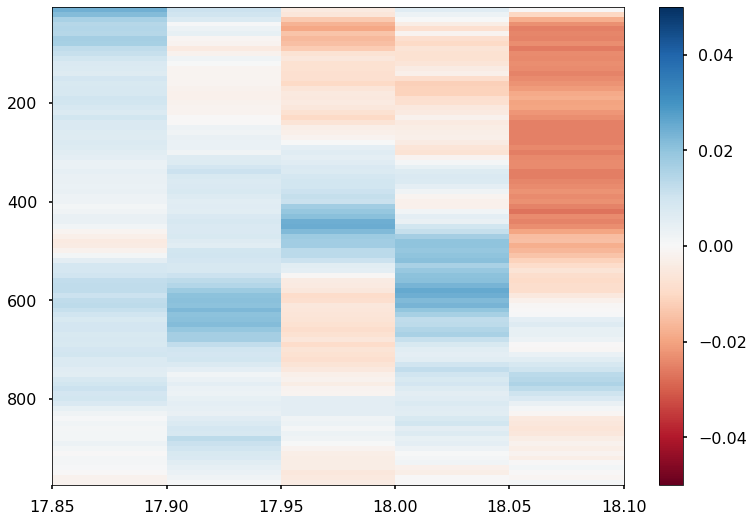

In [603]:
#plt.pcolormesh(grid_ds.lat,grid_ds.depth,grid_ds.v[:,:,4],vmin=-0.1,vmax=0.1,cmap='RdBu')
plt.pcolormesh(grid_ds.lat,grid_ds.depth,np.nanmean(grid_ds.v,axis=2),vmin=-0.05,vmax=0.05,cmap='RdBu')

plt.gca().invert_yaxis()
plt.colorbar()

## Calculate some Transport!

In [604]:
distance = dist_from_lat_lon(lat_grid[0], lon_grid[0], lat_grid[1], lon_grid[0])
distance

5561.491661479939

In [605]:
transport_gridu = np.empty(gridvelu.shape[2])
transport_gridu[:] = np.NaN
transport_gridv = np.empty(gridvelu.shape[2])
transport_gridv[:] = np.NaN

transport_profiles_u = np.empty((gridvelu.shape[0],gridvelu.shape[1],gridvelu.shape[2]))
transport_profiles_u[:] = np.NaN
transport_profiles_v = np.empty((gridvelu.shape[0],gridvelu.shape[1],gridvelu.shape[2]))
transport_profiles_v[:] = np.NaN

transect_transport_profiles_u = np.empty((gridvelu.shape[0],gridvelu.shape[2]))
transect_transport_profiles_u[:] = np.NaN
transect_transport_profiles_v = np.empty((gridvelu.shape[0],gridvelu.shape[2]))
transect_transport_profiles_v[:] = np.NaN

for x in np.arange(0,gridvelu.shape[2]):
    transport_gridu[x] = (np.nansum(gridvelu[:,:,x]*inversion_dz*distance))/(10**6)
    transport_gridv[x] = (np.nansum(gridvelv[:,:,x]*inversion_dz*distance))/(10**6)
    transect_transport_profiles_u[:,x] = np.nanmean((gridvelu[:,:,x]*inversion_dz*distance/(10**6)),axis=1)
    transect_transport_profiles_v[:,x] = np.nanmean((gridvelv[:,:,x]*inversion_dz*distance/(10**6)),axis=1)
    
    for y in np.arange(0,gridvelu.shape[1]):
        transport_profiles_u[:,y,x] = (gridvelu[:,y,x]*inversion_dz*distance)/(10**6)
        transport_profiles_v[:,y,x] = (gridvelv[:,y,x]*inversion_dz*distance)/(10**6)
    

In [606]:
transport_profiles_v.shape

(98, 6, 15)

In [607]:
np.nanmean(transport_profiles_v,axis=2).shape

(98, 6)

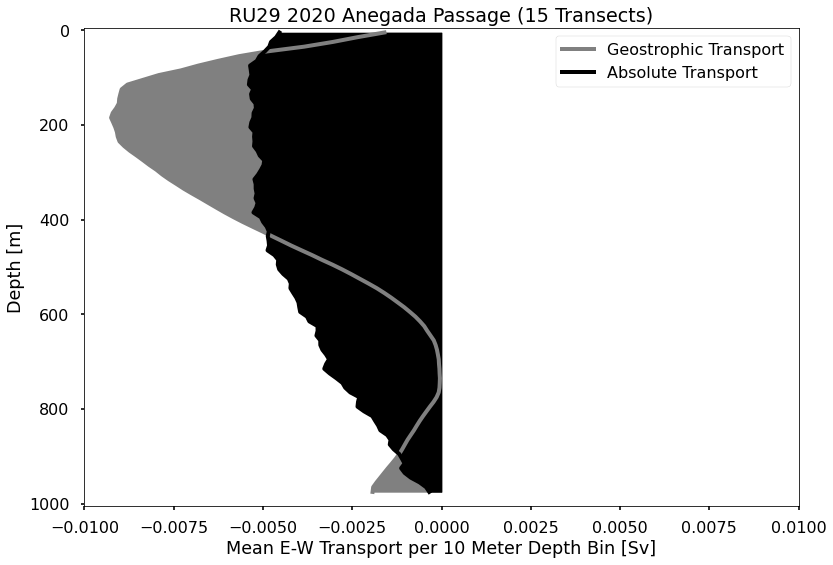

In [608]:

plt.plot(np.nanmean(geo_transect_transport_profiles_u,axis=1),inversion_depth,color='grey',linewidth=4,label='Geostrophic Transport')
plt.fill_betweenx(inversion_depth, 0,np.nanmean(geo_transect_transport_profiles_u,axis=1),color='grey')

plt.plot(np.nanmean(transect_transport_profiles_u,axis=1),inversion_depth,color='black',linewidth=4,label='Absolute Transport')
plt.fill_betweenx(inversion_depth, 0,np.nanmean(transect_transport_profiles_u,axis=1),color='black')


plt.xlim(-0.01,0.01)
plt.ylim(-5,1005)
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('Mean E-W Transport per 10 Meter Depth Bin [Sv]')
plt.title('RU29 2020 Anegada Passage (15 Transects)')
plt.legend()



Text(0.5, 1.0, 'RU29 2020 Anegada Passage')

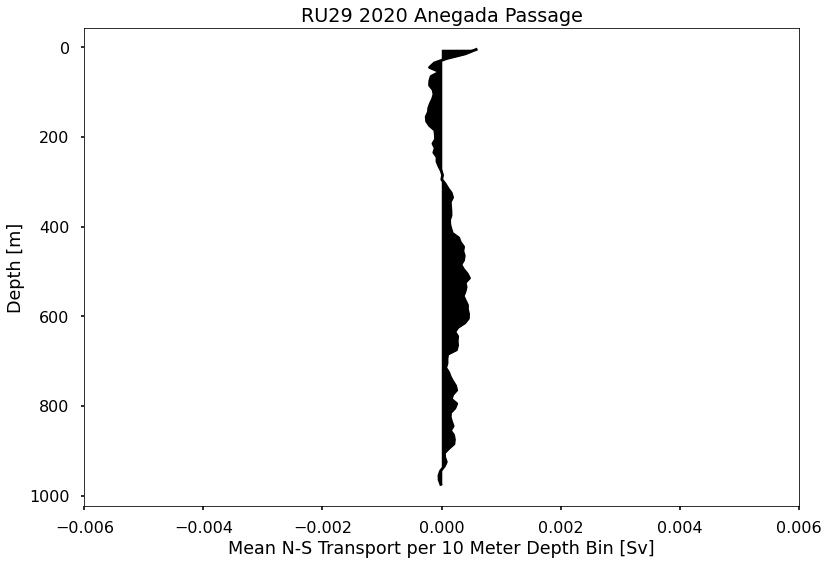

In [609]:
plt.plot(np.nanmean(transect_transport_profiles_v,axis=1),inversion_depth,color='black')
plt.fill_betweenx(inversion_depth, 0,np.nanmean(transect_transport_profiles_v,axis=1),color='black')
plt.xlim(-0.006,0.006)
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('Mean N-S Transport per 10 Meter Depth Bin [Sv]')
plt.title('RU29 2020 Anegada Passage')

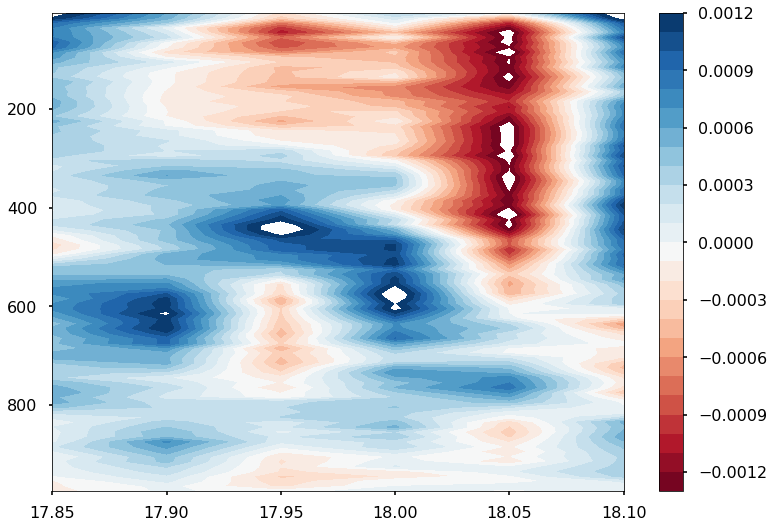

In [610]:
plt.contourf(lat_grid,inversion_depth,np.nanmean(transport_profiles_v,axis=2),levels=np.arange(-0.0013,0.0013,0.0001),cmap='RdBu')
plt.colorbar()
plt.gca().invert_yaxis()

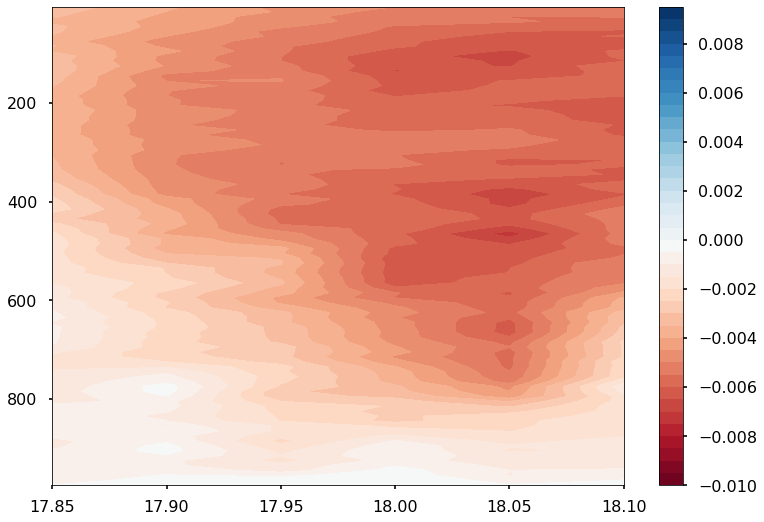

In [611]:
plt.contourf(lat_grid,inversion_depth,np.nanmean(transport_profiles_u,axis=2),levels=np.arange(-0.01,0.01,0.0005),cmap='RdBu')
plt.colorbar()
plt.gca().invert_yaxis()

/tmp/ipykernel_99449/3279869191.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,inversion_depth,np.nanmean(transport_profiles_u,axis=2),vmin=-0.02,vmax=0.02,cmap='RdBu')


Text(0.5, 1.0, 'RU29 2020 Absolute Velocity')

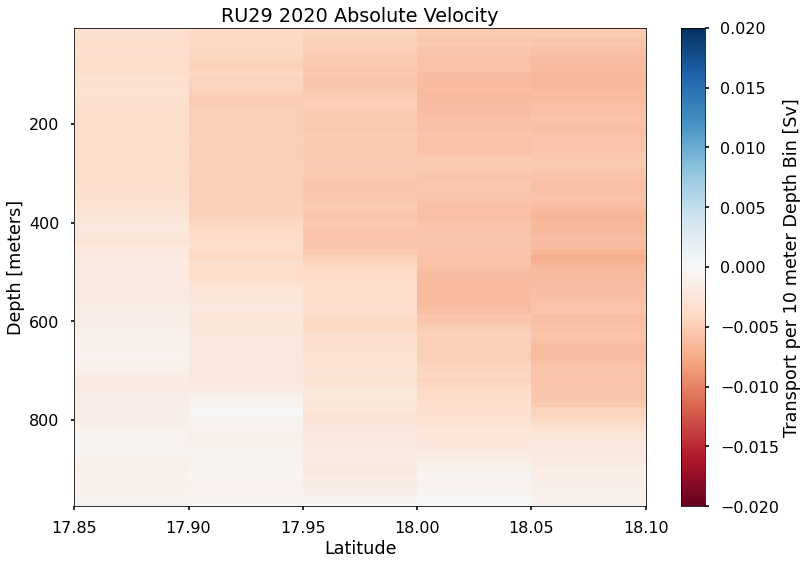

In [616]:
plt.pcolormesh(lat_grid,inversion_depth,np.nanmean(transport_profiles_u,axis=2),vmin=-0.02,vmax=0.02,cmap='RdBu')
#plt.contourf(lat_grid,inversion_depth,np.nanmean(transport_profiles_u,axis=2),levels=np.arange(-0.02,0.02,0.001),cmap='RdBu')

plt.colorbar(label='Transport per 10 meter Depth Bin [Sv]')
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Depth [meters]')
plt.title('RU29 2020 Absolute Velocity')

/tmp/ipykernel_99449/2453277329.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_grid,inversion_depth,np.nanmean(geo_transport_profiles_u,axis=2),vmin=-0.02,vmax=0.02,cmap='RdBu')


Text(0.5, 1.0, 'RU29 2020 Geostrophic Velocity')

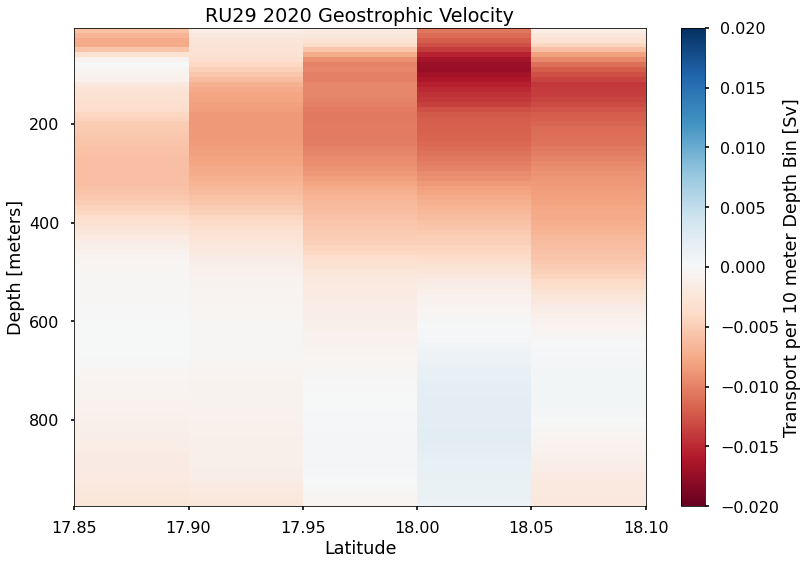

In [617]:
plt.pcolormesh(lat_grid,inversion_depth,np.nanmean(geo_transport_profiles_u,axis=2),vmin=-0.02,vmax=0.02,cmap='RdBu')
#plt.contourf(lat_grid,inversion_depth,np.nanmean(geo_transport_profiles_u,axis=2),levels=np.arange(-0.02,0.02,0.001),cmap='RdBu')

plt.colorbar(label='Transport per 10 meter Depth Bin [Sv]')
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Depth [meters]')
plt.title('RU29 2020 Geostrophic Velocity')

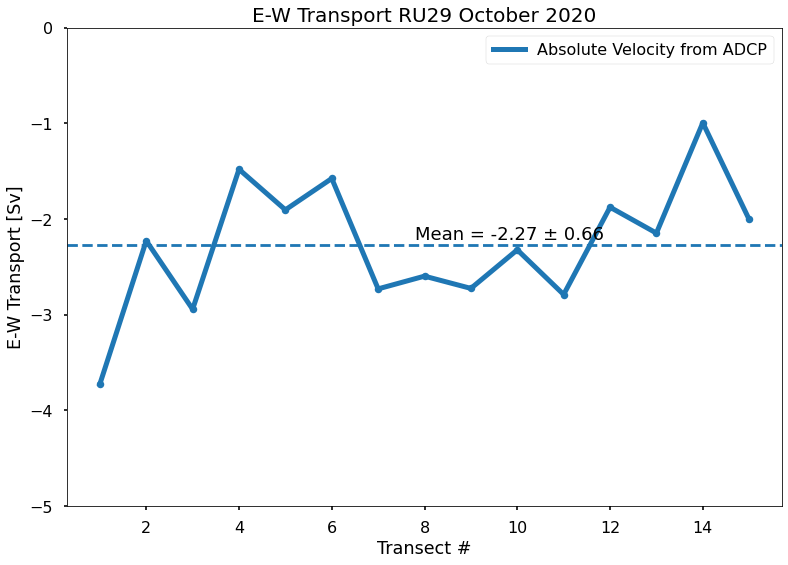

In [628]:
plt.plot(np.arange(1,16),transport_gridu, linewidth=5,color='tab:blue',label='Absolute Velocity from ADCP')
plt.plot(np.arange(1,16),transport_gridu, '.',color='tab:blue',markersize=15)
plt.ylabel('E-W Transport [Sv]')
plt.xlabel('Transect #')
plt.ylim(-5,0)
plt.axhline(y=np.nanmean(transport_gridu), color='tab:blue', linestyle='--')
plt.text(7.8, np.nanmean(transport_gridu)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(transport_gridu),2),np.round(np.nanstd(transport_gridu),2)),fontsize=18);
plt.title('E-W Transport RU29 October 2020',fontsize=20)

plt.legend()


## Plot the three methods together

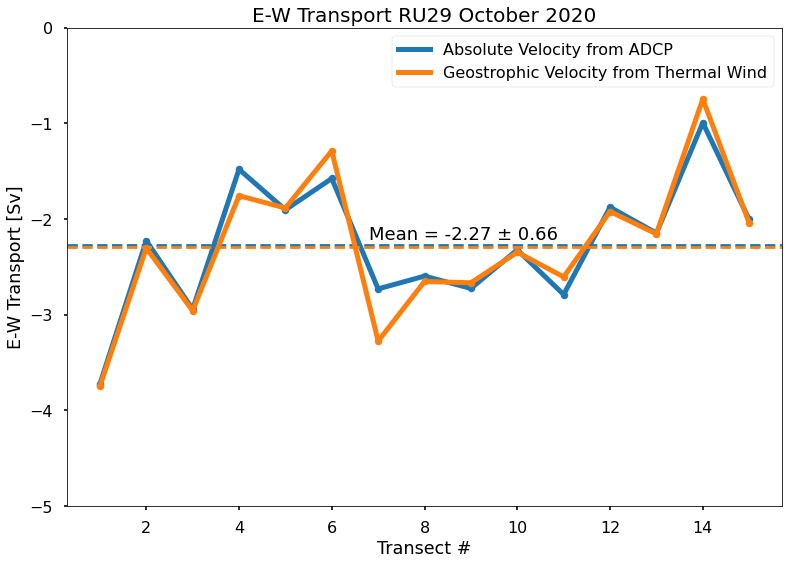

In [629]:
plt.plot(np.arange(1,16),transport_gridu, linewidth=5,color='tab:blue',label='Absolute Velocity from ADCP')
plt.plot(np.arange(1,16),transport_gridu, '.',color='tab:blue',markersize=15)
plt.axhline(y=np.nanmean(transport_gridu), color='tab:blue', linestyle='--')
plt.text(6.8, np.nanmean(transport_gridu)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(transport_gridu),2),np.round(np.nanstd(transport_gridu),2)),fontsize=18);


plt.plot(np.arange(1,16),geo_transport_gridu, linewidth=5,color='tab:orange',label='Geostrophic Velocity from Thermal Wind')
plt.plot(np.arange(1,16),geo_transport_gridu, '.',color='tab:orange',markersize=15)
plt.axhline(y=np.nanmean(geo_transport_gridu), color='tab:orange', linestyle='--')

plt.ylabel('E-W Transport [Sv]')
plt.xlabel('Transect #')
plt.ylim(-5,0)
plt.title('E-W Transport RU29 October 2020',fontsize=20)


plt.legend()


Text(0.5, 1.0, 'N-S Transport RU29 October 2020')

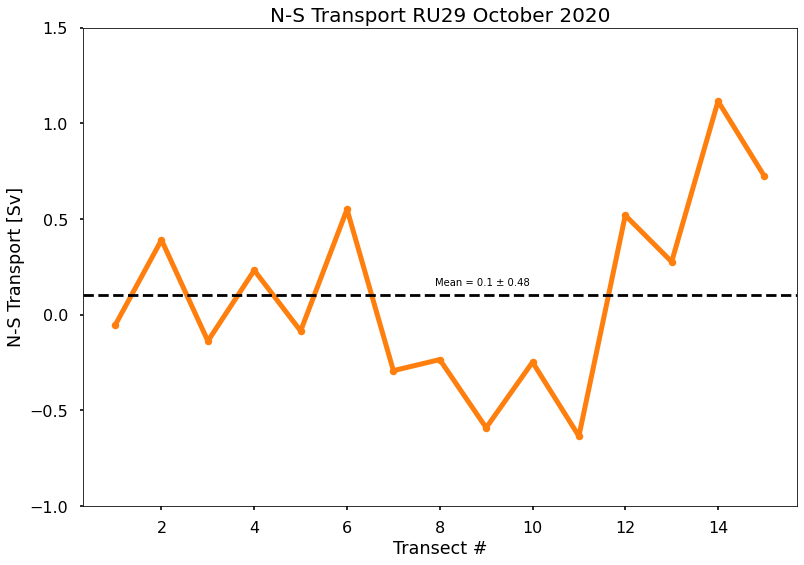

In [567]:
plt.plot(np.arange(1,16),transport_gridv, linewidth=5,color='tab:orange')
plt.plot(np.arange(1,16),transport_gridv, '.',color='tab:orange',markersize=15)
plt.ylabel('N-S Transport [Sv]')
plt.xlabel('Transect #')
plt.ylim(-1,1.5)
plt.axhline(y=np.nanmean(transport_gridv), color='k', linestyle='--')
plt.text(7.9, np.nanmean(transport_gridv)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(transport_gridv),2),np.round(np.nanstd(transport_gridv),2)));
plt.title('N-S Transport RU29 October 2020',fontsize=20)
     

# Make a map of the transects

/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


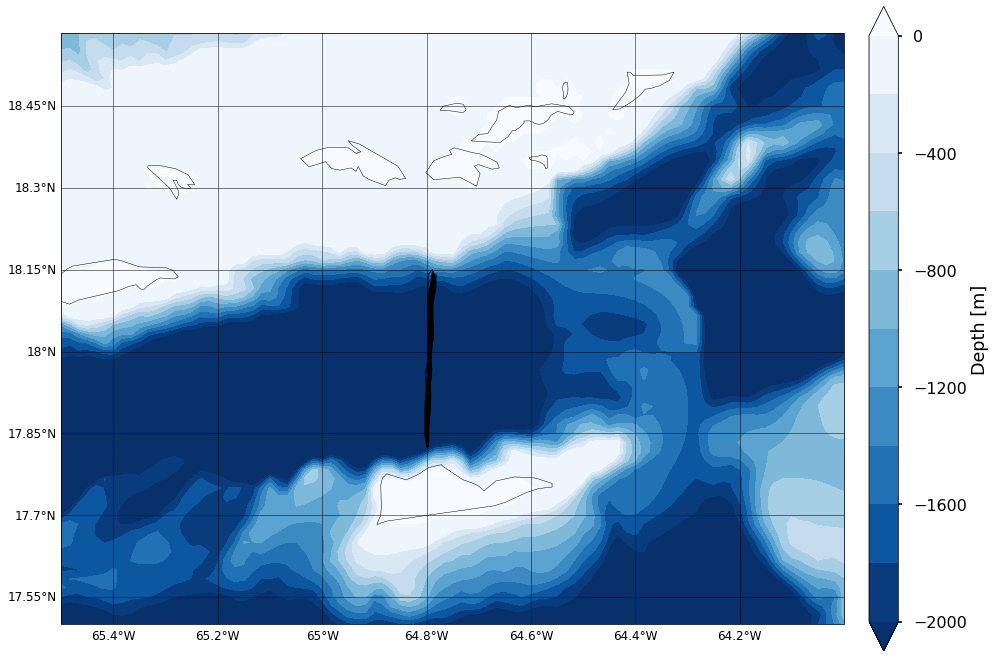

In [568]:
# grab bathymetry data for a map
import cartopy.crs as ccrs

#lat_lims = [16, 19]
#lon_lims = [-66.5, -60.5]
## Zoomed window
lat_lims = [17.5, 18.6]
lon_lims = [-65.5, -64]


# grab some bathymetry
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'

etopo1 = xr.open_dataset(url).sel(lat = slice(lat_lims[0], lat_lims[1]), lon = slice(lon_lims[0], lon_lims[1] ))

fig = plt.figure(figsize=(15,20))
ax = plt.subplot( projection= ccrs.Mercator())

## Good but too smooth
dpth_contours = np.arange(-2000, 1, 200)
## Good but want more resolution at the shelf break
#dpth_contours = np.append(np.arange(-5000, -2000, 500), np.arange(-2000, 1, 1000)) 


#dpth_contours = np.append(np.arange(-5000, -1000, 1000), np.arange(-1000, 1, 500)) 
#plt.plot(gdf.longitude.values, gdf.latitude.values, 'k',linewidth=6, transform=ccrs.PlateCarree(),color='black')


start = 0
end = -1
gdf_sect = gdf.loc[(gdf.time >= sect_times.starttime.values[start]) & (gdf.time <= sect_times.endtime.values[end])]
subset_ds_sect = ds.sel(time=slice(sect_times.starttime.values[start], sect_times.endtime.values[end]))


plt.plot(subset_ds_sect.longitude, subset_ds_sect.latitude,linewidth=1, transform=ccrs.PlateCarree(),color='black')
#plt.plot(gdf_sect.longitude.values, gdf_sect.latitude.values,linewidth=1, transform=ccrs.PlateCarree(),color='red')


plt.contourf(etopo1.lon, etopo1.lat, etopo1.topo, dpth_contours, transform=ccrs.PlateCarree(), cmap='Blues_r', zorder=0,extend='both')
plt.colorbar(label='Depth [m]',pad=0.03, fraction=0.035)
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='black',linewidth=0.5)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

#plt.savefig('/Users/joegradone/Desktop/RU29_2021_Anegada_Map.png',dpi=300,facecolor='white')

## Now look into transport per temperature range

In [637]:
mean_temp = np.nanmean(gridtemp,axis=2)
mean_u_transport = np.nanmean(transport_profiles_u,axis=2)

/tmp/ipykernel_99449/3922338275.py:1: RuntimeWarning: Mean of empty slice
  mean_temp = np.nanmean(gridtemp,axis=2)


In [649]:
ind1 = np.where(mean_temp<7)
print('Transport <7 degrees C',np.round(np.nansum(mean_u_transport[ind1]),3),'Sv')

ind2 = np.where(mean_temp>7)
print('Transport >7 degrees C',np.round(np.nansum(mean_u_transport[ind2]),3),'Sv')

ind3 = np.where((mean_temp>7) & (mean_temp<12))
print('Transport between 7-12 degrees C',np.round(np.nansum(mean_u_transport[ind3]),3),'Sv')

ind4 = np.where((mean_temp>12) & (mean_temp<17))
print('Transport between 12-17 degrees C',np.round(np.nansum(mean_u_transport[ind4]),3),'Sv')

ind5 = np.where((mean_temp>17) & (mean_temp<24))
print('Transport between 17-24 degrees C',np.round(np.nansum(mean_u_transport[ind5]),3),'Sv')

ind6 = np.where((mean_temp>12) & (mean_temp<24))
print('Transport between 12-24 degrees C',np.round(np.nansum(mean_u_transport[ind6]),3),'Sv')

ind7 = np.where(mean_temp>24)
print('Transport >24 degrees C',np.round(np.nansum(mean_u_transport[ind7]),3),'Sv')

Transport <7 degrees C -0.158 Sv
Transport >7 degrees C -2.115 Sv
Transport between 7-12 degrees C -0.56 Sv
Transport between 12-17 degrees C -0.566 Sv
Transport between 17-24 degrees C -0.58 Sv
Transport between 12-24 degrees C -1.146 Sv
Transport >24 degrees C -0.409 Sv


In [650]:
np.nansum(mean_u_transport)

-2.2748689239361495

In [648]:
0.158+0.56+0.56+0.58+0.409

2.267